#Imports

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from keras.layers import Dense,Activation
from keras.optimizers import SGD,RMSprop,Adam
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


%config InlineBackend.figure_format = 'png'
%matplotlib inline


Using TensorFlow backend.


# Mounting Google Drive


In [0]:
# Install a Drive FUSE wrapper.

# https://github.com/astrada/google-drive-ocamlfuse

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131322 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.


!mkdir -p drive

!google-drive-ocamlfuse drive 

#Linear Regression
##Reading Data

In [0]:
#Reading training data
train = pd.read_csv("drive/DL_labs/Lab_1/housing_train.csv")
#Reading testing data
test = pd.read_csv("drive/DL_labs/Lab_1/housing_test.csv")

In [0]:
train.shape

(1460, 81)

#Data Cleaning

In [65]:
train['LotAreaSquare'] = train['LotArea']**2
test['LotAreaSquare'] = test['LotArea']**2
train['GarageAreaSquare'] = train['GarageArea']**2
test['GarageAreaSquare'] = test['GarageArea']**2
#all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))
#all_data = pd.concat((train.loc[:,'MSSubClass':'LotAreaSquare'],test.loc[:,'MSSubClass':'LotAreaSquare']))
all_data = pd.concat((train.loc[:,'MSSubClass':'GarageAreaSquare'],test.loc[:,'MSSubClass':'GarageAreaSquare']))
all_data = all_data.drop(columns=['SaleCondition'])
all_data = all_data.drop(columns=['LotArea'])
all_data = all_data.drop(columns=['GarageArea'])

print(all_data.shape)

train["SalePrice"] = np.log1p(train["SalePrice"])

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index



all_data[skewed_feats] = np.log1p(all_data[skewed_feats])



all_data = pd.get_dummies(all_data)



all_data = all_data.fillna(all_data.mean())


X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice



X_train = StandardScaler().fit_transform(X_train)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)
print(X_tr.shape)
print(X_val.shape)

(2919, 79)
(1095, 283)
(365, 283)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#Building the Model

In [0]:
model = Sequential()
output_dimension = 1
input_dimension = 283 #After applying dummy variables trick to convert from categorical to numerical attributes
dense_layer = Dense(output_dimension, input_dim = input_dimension)
activation_layer = Activation('linear')
model.add(dense_layer)
model.add(activation_layer)
learning_rate = 0.01
momentum = 0.001
optimizer = SGD(lr=learning_rate, momentum= momentum, )

#Model Compilation

In [0]:
model.compile(loss = "mse", optimizer = optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1)                 284       
_________________________________________________________________
activation_14 (Activation)   (None, 1)                 0         
Total params: 284
Trainable params: 284
Non-trainable params: 0
_________________________________________________________________


#Model Fitting & Prediction

Train on 1095 samples, validate on 365 samples
Epoch 1/150
1095/1095 [==============================] - 1s 600us/step - loss: 89.8659 - val_loss: 54.8676
Epoch 2/150
1095/1095 [==============================] - 0s 107us/step - loss: 21.0051 - val_loss: 24.1387
Epoch 3/150
1095/1095 [==============================] - 0s 99us/step - loss: 5.7907 - val_loss: 15.6203
Epoch 4/150
1095/1095 [==============================] - 0s 117us/step - loss: 1.9225 - val_loss: 12.5816
Epoch 5/150
1095/1095 [==============================] - 0s 86us/step - loss: 0.9741 - val_loss: 11.1289
Epoch 6/150
1095/1095 [==============================] - 0s 84us/step - loss: 0.6352 - val_loss: 10.2134
Epoch 7/150
1095/1095 [==============================] - 0s 90us/step - loss: 0.5503 - val_loss: 9.7422
Epoch 8/150
1095/1095 [==============================] - 0s 85us/step - loss: 0.4030 - val_loss: 9.4200
Epoch 9/150
1095/1095 [==============================] - 0s 91us/step - loss: 0.3643 - val_loss: 9.4069
Epoch 

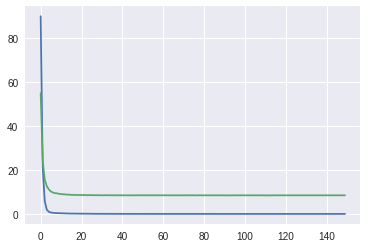

In [0]:
#Fitting the model

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min')
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = 150 )
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])


In [0]:
#Predicting the model
model.evaluate(X_val, y_val, verbose=0)
#print(model.predict(X_test))
#pd.Series(model.predict(X_test)[:,0]).hist()

8.45585905750703

#Logistic Regression

In [93]:
dataset = pd.read_csv("drive/DL_labs/Lab_1/heart.csv")

X = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

#training set
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, random_state=0)
#Validation Set
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, train_size=0.9, random_state=0)



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#Building the model

In [0]:
model = Sequential()
output_dimension = 1
input_dimension = 13 
dense_layer = Dense(output_dimension, input_dim = input_dimension)
activation_layer = Activation('sigmoid')
model.add(dense_layer)
model.add(activation_layer)
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)


#Fitting the Model

Train on 204 samples, validate on 23 samples
Epoch 1/50
204/204 [==============================] - 2s 10ms/step - loss: 5.1839 - acc: 0.5833 - val_loss: 4.1659 - val_acc: 0.6957
Epoch 2/50
204/204 [==============================] - 0s 2ms/step - loss: 4.6205 - acc: 0.6225 - val_loss: 1.6430 - val_acc: 0.8261
Epoch 3/50
204/204 [==============================] - 0s 2ms/step - loss: 4.7832 - acc: 0.5882 - val_loss: 5.5474 - val_acc: 0.6522
Epoch 4/50
204/204 [==============================] - 0s 2ms/step - loss: 4.2083 - acc: 0.6373 - val_loss: 0.6527 - val_acc: 0.7826
Epoch 5/50
204/204 [==============================] - 1s 2ms/step - loss: 4.4423 - acc: 0.6275 - val_loss: 5.3973 - val_acc: 0.6522
Epoch 6/50
204/204 [==============================] - 0s 2ms/step - loss: 4.2641 - acc: 0.6373 - val_loss: 1.5749 - val_acc: 0.8261
Epoch 7/50
204/204 [==============================] - 0s 2ms/step - loss: 3.6113 - acc: 0.6814 - val_loss: 1.6588 - val_acc: 0.7826
Epoch 8/50
204/204 [==========

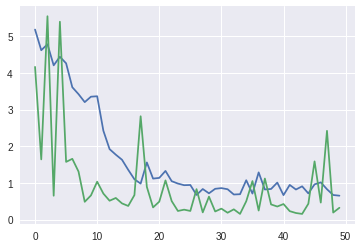

In [105]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=optimizer)
hist = model.fit(train_X, train_y, validation_data = (val_X, val_y),verbose=1, batch_size=2, epochs=50)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])


#Predicting 

In [106]:
score, accuracy = model.evaluate(test_X, test_y, batch_size=16, verbose=0)
print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))


Test fraction correct (NN-Score) = 0.84
Test fraction correct (NN-Accuracy) = 0.83
